### Single survey POC

In [4]:
import sys
import os
from reverie import ReverieServer
from tqdm import tqdm
from contextlib import contextmanager

@contextmanager
def suppress_output():
    # Save the current stdout
    original_stdout = sys.stdout
    # Redirect stdout to the null device
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        # Restore the original stdout
        sys.stdout.close()
        sys.stdout = original_stdout

In [2]:
# remove temp folder if it exists
if os.path.exists("../../environment/frontend_server/storage/_temp"):
    os.system("rm -rf ../../environment/frontend_server/storage/_temp")

PATH = "base_the_ville_smol_elections_5_voters_2days/base_the_ville_smol_elections_5_voters_2days-s-142-15463-15594"

rs = ReverieServer(PATH, "_temp")

In [3]:
# with suppress_output():
#     o = rs.personas["Maria Lopez"].open_convo_session("analysis", direct=True, question="Who are you planning to vote in the coming elections?")

In [5]:
survey_question = "Who are you planning to vote in the coming elections?"

convos = []
for persona in tqdm(rs.personas.values()):
    with suppress_output():
        convos.append(persona.open_convo_session("analysis", direct=True, question=survey_question)[-1])


100%|██████████| 7/7 [00:24<00:00,  3.50s/it]


In [6]:
convos

[['Isabella Rodriguez',
  'I am still in the process of evaluating the candidates Klaus Mauller and Maria Lopez for the upcoming town elections. I am planning to discuss my thoughts on this matter with Adam Smith over coffee at Hobbs Cafe tomorrow. I want to make an informed decision and consider the best candidate for our community.'],
 ['Maria Lopez',
  "I'm still undecided at the moment. I'm researching and learning more about the candidates and their policies before making my decision. It's important to me to make an informed choice based on the issues that matter most to me and my community."],
 ['Klaus Mueller',
  "I haven't decided yet. I'm still gathering information on the candidates and their platforms. I think it's important to make an informed decision based on their stance on issues that matter to me, like social justice and community development."],
 ['Abigail Chen',
  "I'm still exploring all the candidates' proposals and attending events to understand their platforms be

In [20]:
import persona.prompt_template.gpt_structure as gpt_structure

gpt_param = {"engine": "gpt-35-turbo-0125", "max_tokens": 250, 
            "temperature": 0, "top_p": 1, "stream": False,
            "frequency_penalty": 0, "presence_penalty": 0, "stop": None}

extract_prompt = "You are given a response to a survey question \"Who are you planning to vote in the coming elections?\". Extract and write the name of the candidate mentioned in the response or write None if the responder have not decided yet. Respond with the name of the candidate or None. Response: {response}"

In [25]:
for convo in convos:
    print(f"Person: {convo[0]}")
    print(f"Response: {convo[-1]}")
    print(f"Predicted: {gpt_structure.GPT_request(extract_prompt.format(response=convo[-1]), gpt_param)}")
    print("\n\n")

Person: Isabella Rodriguez
Response: I am still in the process of evaluating the candidates Klaus Mauller and Maria Lopez for the upcoming town elections. I am planning to discuss my thoughts on this matter with Adam Smith over coffee at Hobbs Cafe tomorrow. I want to make an informed decision and consider the best candidate for our community.
Predicted: None



Person: Maria Lopez
Response: I'm still undecided at the moment. I'm researching and learning more about the candidates and their policies before making my decision. It's important to me to make an informed choice based on the issues that matter most to me and my community.
Predicted: None



Person: Klaus Mueller
Response: I haven't decided yet. I'm still gathering information on the candidates and their platforms. I think it's important to make an informed decision based on their stance on issues that matter to me, like social justice and community development.
Predicted: None



Person: Abigail Chen
Response: I'm still explo

### Multisurvey

In [22]:
import sys
import os
import pickle
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from contextlib import contextmanager

import persona.prompt_template.gpt_structure as gpt_structure
from reverie import ReverieServer

sns.set_style("whitegrid")


@contextmanager
def suppress_output():
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stdout.close()
        sys.stdout = original_stdout

def get_folders(path):
    return [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

def get_files(path, str_in_name=None):
    if str_in_name is None:
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    else:
        files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and str_in_name in f]
    files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    return files

def clean_start_server(path):
    if os.path.exists("../../environment/frontend_server/storage/_temp"):
        os.system("rm -rf ../../environment/frontend_server/storage/_temp")

    rs = ReverieServer(path, "_temp")
    return rs

def get_survey_responses(rs, survey_question):
    convos = []
    for persona in tqdm(rs.personas.values()):
        with suppress_output():
            convos.append(persona.open_convo_session("analysis", direct=True, question=survey_question)[-1])
    return convos

def extract_survey_responses(convos, extract_prompt, gpt_param):
    predictions = []
    for convo in convos:
        predictions.append((convo[-1], gpt_structure.GPT_request(extract_prompt.format(response=convo[-1]), gpt_param)))
    return predictions

def update_results(results, predictions):
    for i, (response, prediction) in enumerate(predictions):
        if prediction in results:
            results[prediction] += 1
        else:
            results[prediction] = 1
    return results

def save_file(results, path):
    with open(path, "wb") as f:
        pickle.dump(results, f)

def load_file(path):
    with open(path, "rb") as f:
        return pickle.load(f)

gpt_param = {"engine": "gpt-35-turbo-0125", "max_tokens": 250, 
            "temperature": 0, "top_p": 1, "stream": False,
            "frequency_penalty": 0, "presence_penalty": 0, "stop": None}

extract_survey_prompt = "You are given a response to a survey question \"Who are you planning to vote in the coming elections?\". Extract and write the name of the candidate mentioned in the response or write None if the responder have not decided yet. The two candidates that are running are: Klaus Mueller and Maria Lopez. Respond with the name of the candidate or None. Response: {response}"

In [17]:
PATH_SIM = "base_the_ville_smol_elections_5_voters_2days"

folders = get_folders(f"../../environment/frontend_server/storage/{PATH_SIM}")
folders_sorted = sorted(folders, key=lambda x: int(x.split("-")[-3]))

SAVE_PATH = "survey/"
curr_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")

results = []
all_convos = []
all_predictions = []
df_survey = pd.DataFrame(columns=list(map(lambda x: x.split("-")[-3], folders_sorted)))
if input("Load last results? (y/n): ") == "y":
    results = load_file(get_files(SAVE_PATH, "results")[-1])
    all_convos = load_file(get_files(SAVE_PATH, "convos")[-1])
    all_predictions = load_file(get_files(SAVE_PATH, "predictions")[-1])
    print(results)
else:
    counter = 0
    for PATH_STAGE in tqdm(folders_sorted):
        rs = clean_start_server(f"{PATH_SIM}/{PATH_STAGE}")
        convos = get_survey_responses(rs, "Who are you planning to vote in the coming elections?")
        predictions = extract_survey_responses(convos, extract_survey_prompt, gpt_param)
        
        results.append(
            update_results({"step": PATH_STAGE.split("-")[-2], "file_stage": PATH_STAGE.split("-")[-3], "loop_stage": counter}, predictions))
        all_convos.append(convos)
        all_predictions.append(predictions)

        save_file(results, f"{SAVE_PATH}/results_{curr_datetime}.pkl")
        save_file(all_convos, f"{SAVE_PATH}/convos_{curr_datetime}.pkl")
        save_file(all_predictions, f"{SAVE_PATH}/predictions_{curr_datetime}.pkl")

        counter += 1
        print(results[-1])

  1%|          | 1/151 [00:31<1:17:36, 31.04s/it]

{'step': '0', 'None': 7}


  1%|▏         | 2/151 [01:01<1:16:37, 30.85s/it]

{'step': '199', 'None': 7}


  2%|▏         | 3/151 [01:29<1:12:02, 29.21s/it]

{'step': '399', 'None': 7}


  3%|▎         | 4/151 [02:00<1:13:34, 30.03s/it]

{'step': '599', 'None': 7}


  3%|▎         | 5/151 [02:31<1:13:40, 30.27s/it]

{'step': '799', 'Klaus Mueller': 1, 'None': 6}


  4%|▍         | 6/151 [03:00<1:12:51, 30.15s/it]

{'step': '999', 'None': 7}


  5%|▍         | 7/151 [03:30<1:11:59, 30.00s/it]

{'step': '1199', 'None': 7}


  5%|▌         | 8/151 [04:02<1:12:48, 30.55s/it]

{'step': '1399', 'None': 7}


  6%|▌         | 9/151 [04:31<1:11:06, 30.05s/it]

{'step': '1599', 'None': 7}


  7%|▋         | 10/151 [05:06<1:14:41, 31.78s/it]

{'step': '1799', 'None': 7}


  7%|▋         | 11/151 [05:35<1:12:01, 30.87s/it]

{'step': '1999', 'None': 7}


  8%|▊         | 12/151 [06:05<1:10:50, 30.58s/it]

{'step': '2199', 'None': 7}


  9%|▊         | 13/151 [06:39<1:12:23, 31.48s/it]

{'step': '2399', 'None': 7}


  9%|▉         | 14/151 [07:12<1:13:06, 32.02s/it]

{'step': '2599', 'None': 7}


 10%|▉         | 15/151 [07:42<1:11:32, 31.56s/it]

{'step': '2799', 'None': 7}


 11%|█         | 16/151 [08:14<1:11:12, 31.65s/it]

{'step': '2879', 'None': 7}


 11%|█▏        | 17/151 [08:45<1:09:44, 31.22s/it]

{'step': '2878', 'None': 7}


 12%|█▏        | 18/151 [09:15<1:08:41, 30.99s/it]

{'step': '2877', 'None': 7}


 13%|█▎        | 19/151 [09:45<1:07:34, 30.72s/it]

{'step': '2876', 'None': 7}


 13%|█▎        | 20/151 [10:13<1:04:57, 29.75s/it]

{'step': '2875', 'None': 7}


 14%|█▍        | 21/151 [10:53<1:11:05, 32.81s/it]

{'step': '2874', 'None': 7}


 15%|█▍        | 22/151 [11:25<1:10:24, 32.75s/it]

{'step': '2873', 'None': 7}


 15%|█▌        | 23/151 [12:01<1:11:36, 33.57s/it]

{'step': '2872', 'None': 7}


 16%|█▌        | 24/151 [12:46<1:18:45, 37.21s/it]

{'step': '2871', 'None': 7}


 17%|█▋        | 25/151 [13:26<1:19:59, 38.09s/it]

{'step': '2870', 'None': 7}


 17%|█▋        | 26/151 [14:00<1:16:48, 36.87s/it]

{'step': '2869', 'None': 7}


 18%|█▊        | 27/151 [14:38<1:16:29, 37.01s/it]

{'step': '2868', 'None': 7}


 19%|█▊        | 28/151 [15:10<1:12:54, 35.57s/it]

{'step': '2867', 'None': 7}


 19%|█▉        | 29/151 [15:45<1:12:13, 35.52s/it]

{'step': '2866', 'None': 7}


 20%|█▉        | 30/151 [16:34<1:19:20, 39.34s/it]

{'step': '2865', 'None': 7}


 21%|██        | 31/151 [17:14<1:19:05, 39.55s/it]

{'step': '2864', 'None': 7}


 21%|██        | 32/151 [17:48<1:15:35, 38.12s/it]

{'step': '2863', 'None': 7}


 22%|██▏       | 33/151 [18:23<1:13:06, 37.17s/it]

{'step': '2862', 'None': 7}


 23%|██▎       | 34/151 [19:03<1:14:08, 38.02s/it]

{'step': '2861', 'None': 7}


 23%|██▎       | 35/151 [19:37<1:10:55, 36.69s/it]

{'step': '2860', 'None': 7}


 24%|██▍       | 36/151 [20:17<1:12:12, 37.67s/it]

{'step': '2859', 'None': 7}


 25%|██▍       | 37/151 [20:56<1:12:23, 38.10s/it]

{'step': '2858', 'None': 7}


 25%|██▌       | 38/151 [21:34<1:11:26, 37.94s/it]

{'step': '2857', 'None': 7}


 26%|██▌       | 39/151 [22:05<1:07:18, 36.06s/it]

{'step': '2856', 'None': 7}


 26%|██▋       | 40/151 [22:42<1:07:12, 36.33s/it]

{'step': '2855', 'None': 7}


 27%|██▋       | 41/151 [23:17<1:05:37, 35.80s/it]

{'step': '2854', 'None': 7}


 28%|██▊       | 42/151 [23:51<1:04:22, 35.43s/it]

{'step': '2853', 'None': 7}


 28%|██▊       | 43/151 [24:22<1:01:10, 33.99s/it]

{'step': '2852', 'None': 7}


 29%|██▉       | 44/151 [24:57<1:01:03, 34.24s/it]

{'step': '2851', 'None': 7}


 30%|██▉       | 45/151 [25:30<1:00:00, 33.96s/it]

{'step': '2850', 'None': 7}


 30%|███       | 46/151 [26:10<1:02:31, 35.73s/it]

{'step': '2849', 'None': 7}


 31%|███       | 47/151 [26:45<1:01:27, 35.45s/it]

{'step': '2848', 'None': 7}


 32%|███▏      | 48/151 [27:21<1:01:01, 35.55s/it]

{'step': '2847', 'None': 7}


 32%|███▏      | 49/151 [27:59<1:01:40, 36.28s/it]

{'step': '2998', 'None': 7}


 33%|███▎      | 50/151 [28:36<1:01:39, 36.63s/it]

{'step': '3198', 'None': 7}


 34%|███▍      | 51/151 [29:15<1:02:20, 37.41s/it]

{'step': '3398', 'None': 7}


 34%|███▍      | 52/151 [29:50<1:00:20, 36.57s/it]

{'step': '3598', 'None': 7}


 35%|███▌      | 53/151 [30:28<1:00:38, 37.12s/it]

{'step': '3798', 'None': 7}


 36%|███▌      | 54/151 [31:07<1:00:54, 37.68s/it]

{'step': '3998', 'None': 7}


 36%|███▋      | 55/151 [31:48<1:01:48, 38.63s/it]

{'step': '4198', 'None': 5, 'Klaus Mueller': 2}


 37%|███▋      | 56/151 [32:55<1:14:45, 47.21s/it]

{'step': '4398', 'None': 5, 'Maria Lopez': 1, 'Klaus Mueller': 1}


 38%|███▊      | 57/151 [33:41<1:13:08, 46.68s/it]

{'step': '4598', 'None': 7}


 38%|███▊      | 58/151 [34:23<1:10:18, 45.36s/it]

{'step': '4778', 'None': 7}


 39%|███▉      | 59/151 [35:08<1:09:28, 45.30s/it]

{'step': '4797', 'None': 5, 'Maria Lopez': 1, 'Klaus Mueller': 1}


 40%|███▉      | 60/151 [35:48<1:06:18, 43.72s/it]

{'step': '4975', 'None': 6, 'Klaus Mueller': 1}


 40%|████      | 61/151 [36:35<1:06:48, 44.54s/it]

{'step': '4996', 'None': 6, 'Klaus Mueller': 1}


 41%|████      | 62/151 [37:18<1:05:33, 44.20s/it]

{'step': '5196', 'None': 6, 'Klaus Mueller': 1}


 42%|████▏     | 63/151 [37:56<1:02:00, 42.28s/it]

{'step': '5396', 'None': 6, 'Maria Lopez': 1}


 42%|████▏     | 64/151 [38:44<1:03:38, 43.89s/it]

{'step': '5596', 'None': 6, 'Maria Lopez': 1}


 43%|████▎     | 65/151 [39:23<1:00:51, 42.46s/it]

{'step': '5796', 'None': 6, 'Klaus Mueller': 1}


 44%|████▎     | 66/151 [40:07<1:01:00, 43.06s/it]

{'step': '5996', 'None': 7}


 44%|████▍     | 67/151 [40:55<1:02:18, 44.50s/it]

{'step': '6196', 'None': 7}


 45%|████▌     | 68/151 [41:45<1:03:43, 46.06s/it]

{'step': '6396', 'None': 6, 'Maria Lopez': 1}


 46%|████▌     | 69/151 [42:26<1:00:57, 44.61s/it]

{'step': '6450', 'None': 6, 'Maria Lopez': 1}


 46%|████▋     | 70/151 [43:23<1:05:20, 48.40s/it]

{'step': '6449', 'Klaus Mueller': 1, 'None': 6}


 47%|████▋     | 71/151 [44:12<1:04:39, 48.50s/it]

{'step': '6448', 'Maria Lopez': 1, 'None': 6}


 48%|████▊     | 72/151 [45:05<1:05:35, 49.82s/it]

{'step': '6595', 'None': 7}


 48%|████▊     | 73/151 [45:54<1:04:31, 49.63s/it]

{'step': '6795', 'None': 6, 'Maria Lopez': 1}


 49%|████▉     | 74/151 [46:43<1:03:26, 49.43s/it]

{'step': '6995', 'None': 6, 'Maria Lopez': 1}


 50%|████▉     | 75/151 [47:31<1:02:03, 49.00s/it]

{'step': '7195', 'Klaus Mueller': 1, 'None': 6}


 50%|█████     | 76/151 [48:23<1:02:17, 49.84s/it]

{'step': '7395', 'None': 7}


 51%|█████     | 77/151 [49:06<59:11, 47.99s/it]  

{'step': '7595', 'None': 6, 'Klaus Mueller': 1}


 52%|█████▏    | 78/151 [49:52<57:34, 47.32s/it]

{'step': '7795', 'None': 6, 'Klaus Mueller': 1}


 52%|█████▏    | 79/151 [50:43<58:09, 48.47s/it]

{'step': '7995', 'None': 7}


 53%|█████▎    | 80/151 [51:32<57:26, 48.54s/it]

{'step': '8195', 'None': 6, 'Maria Lopez': 1}


 54%|█████▎    | 81/151 [52:20<56:23, 48.34s/it]

{'step': '8395', 'None': 6, 'Klaus Mueller': 1}


 54%|█████▍    | 82/151 [53:05<54:26, 47.34s/it]

{'step': '8595', 'None': 6, 'Maria Lopez': 1}


 55%|█████▍    | 83/151 [53:50<52:52, 46.66s/it]

{'step': '8795', 'None': 6, 'Maria Lopez': 1}


 56%|█████▌    | 84/151 [54:40<53:16, 47.71s/it]

{'step': '8995', 'None': 6, 'Maria Lopez': 1}


 56%|█████▋    | 85/151 [55:33<54:18, 49.37s/it]

{'step': '9195', 'None': 6, 'Maria Lopez': 1}


 57%|█████▋    | 86/151 [56:27<54:57, 50.73s/it]

{'step': '9395', 'None': 7}


 58%|█████▊    | 87/151 [57:23<55:32, 52.07s/it]

{'step': '9595', 'Maria Lopez': 2, 'None': 5}


 58%|█████▊    | 88/151 [58:07<52:07, 49.65s/it]

{'step': '9795', 'None': 6, 'Maria Lopez': 1}


 59%|█████▉    | 89/151 [58:53<50:24, 48.78s/it]

{'step': '9995', 'None': 6, 'Maria Lopez': 1}


 60%|█████▉    | 90/151 [59:44<50:03, 49.23s/it]

{'step': '10195', 'Maria Lopez': 3, 'None': 3, 'Klaus Mueller': 1}


 60%|██████    | 91/151 [1:00:36<50:04, 50.08s/it]

{'step': '10395', 'None': 5, 'Maria Lopez': 2}


 61%|██████    | 92/151 [1:01:22<48:12, 49.03s/it]

{'step': '10595', 'None': 6, 'Maria Lopez': 1}


 62%|██████▏   | 93/151 [1:02:17<49:07, 50.82s/it]

{'step': '10795', 'None': 6, 'Maria Lopez': 1}


 62%|██████▏   | 94/151 [1:03:09<48:26, 51.00s/it]

{'step': '10995', 'None': 6, 'Maria Lopez': 1}


 63%|██████▎   | 95/151 [1:04:20<53:14, 57.05s/it]

{'step': '11145', 'None': 5, 'Maria Lopez': 2}


 64%|██████▎   | 96/151 [1:05:14<51:28, 56.15s/it]

{'step': '11194', 'None': 6, 'Maria Lopez': 1}


 64%|██████▍   | 97/151 [1:06:10<50:28, 56.09s/it]

{'step': '11394', 'None': 6, 'Maria Lopez': 1}


 65%|██████▍   | 98/151 [1:07:00<48:04, 54.43s/it]

{'step': '11594', 'None': 6, 'Maria Lopez': 1}


 66%|██████▌   | 99/151 [1:07:45<44:33, 51.42s/it]

{'step': '11794', 'None': 6, 'Maria Lopez': 1}


 66%|██████▌   | 100/151 [1:08:42<45:06, 53.07s/it]

{'step': '11994', 'None': 6, 'Maria Lopez': 1}


 67%|██████▋   | 101/151 [1:09:31<43:13, 51.86s/it]

{'step': '12194', 'None': 6, 'Maria Lopez': 1}


 68%|██████▊   | 102/151 [1:10:22<42:09, 51.63s/it]

{'step': '12394', 'None': 5, 'Maria Lopez': 2}


 68%|██████▊   | 103/151 [1:11:12<41:02, 51.31s/it]

{'step': '12594', 'None': 5, 'Maria Lopez': 2}


 69%|██████▉   | 104/151 [1:12:07<40:56, 52.26s/it]

{'step': '12794', 'None': 6, 'Maria Lopez': 1}


 70%|██████▉   | 105/151 [1:13:01<40:33, 52.91s/it]

{'step': '12994', 'None': 5, 'Maria Lopez': 2}


 70%|███████   | 106/151 [1:13:56<40:01, 53.36s/it]

{'step': '13194', 'Maria Lopez': 3, 'None': 4}


 71%|███████   | 107/151 [1:14:47<38:36, 52.65s/it]

{'step': '13394', 'Maria Lopez': 2, 'None': 5}


 72%|███████▏  | 108/151 [1:15:41<38:09, 53.25s/it]

{'step': '13594', 'Maria Lopez': 3, 'None': 4}


 72%|███████▏  | 109/151 [1:16:28<35:53, 51.26s/it]

{'step': '13794', 'None': 5, 'Maria Lopez': 2}


 73%|███████▎  | 110/151 [1:32:41<3:44:00, 327.81s/it]

{'step': '13994', 'None': 5, 'Maria Lopez': 2}


 74%|███████▎  | 111/151 [3:46:14<29:15:33, 2633.33s/it]

{'step': '14194', 'None': 6, 'Maria Lopez': 1}


 74%|███████▍  | 112/151 [3:46:54<20:05:56, 1855.30s/it]

{'step': '14394', 'None': 5, 'Maria Lopez': 2}


 75%|███████▍  | 113/151 [3:47:33<13:49:57, 1310.45s/it]

{'step': '14594', 'None': 6, 'Maria Lopez': 1}


 75%|███████▌  | 114/151 [3:48:13<9:33:02, 929.27s/it]  

{'step': '14794', 'None': 5, 'Klaus Mueller': 1, 'Maria Lopez': 1}


 76%|███████▌  | 115/151 [3:48:52<6:37:22, 662.28s/it]

{'step': '14994', 'None': 5, 'Maria Lopez': 2}


 77%|███████▋  | 116/151 [3:49:34<4:37:43, 476.09s/it]

{'step': '15194', 'None': 6, 'Maria Lopez': 1}


 77%|███████▋  | 117/151 [3:50:18<3:16:20, 346.47s/it]

{'step': '15394', 'Maria Lopez': 2, 'None': 4, 'Klaus Mueller': 1}


 78%|███████▊  | 118/151 [3:51:01<2:20:30, 255.47s/it]

{'step': '15488', 'Maria Lopez': 2, 'None': 5}


 79%|███████▉  | 119/151 [3:51:42<1:41:53, 191.05s/it]

{'step': '15487', 'None': 5, 'Maria Lopez': 2}


 79%|███████▉  | 120/151 [3:52:23<1:15:29, 146.12s/it]

{'step': '15486', 'None': 5, 'Maria Lopez': 2}


 80%|████████  | 121/151 [3:53:15<58:56, 117.90s/it]  

{'step': '15485', 'None': 5, 'Maria Lopez': 2}


 81%|████████  | 122/151 [3:54:00<46:21, 95.91s/it] 

{'step': '15484', 'None': 4, 'Maria Lopez': 2, 'Klaus Mueller': 1}


 81%|████████▏ | 123/151 [3:54:41<37:09, 79.63s/it]

{'step': '15483', 'None': 5, 'Klaus Mueller': 1, 'Maria Lopez': 1}


 82%|████████▏ | 124/151 [3:55:25<31:01, 68.96s/it]

{'step': '15482', 'None': 5, 'Klaus Mueller': 1, 'Maria Lopez': 1}


 83%|████████▎ | 125/151 [3:56:08<26:31, 61.22s/it]

{'step': '15481', 'None': 6, 'Maria Lopez': 1}


 83%|████████▎ | 126/151 [3:56:50<23:01, 55.28s/it]

{'step': '15480', 'Maria Lopez': 3, 'None': 4}


 84%|████████▍ | 127/151 [3:57:31<20:26, 51.11s/it]

{'step': '15479', 'None': 5, 'Maria Lopez': 2}


 85%|████████▍ | 128/151 [3:58:12<18:22, 47.93s/it]

{'step': '15478', 'None': 6, 'Maria Lopez': 1}


 85%|████████▌ | 129/151 [3:58:52<16:45, 45.69s/it]

{'step': '15477', 'Maria Lopez': 3, 'None': 3, 'Klaus Mueller': 1}


 86%|████████▌ | 130/151 [3:59:32<15:25, 44.05s/it]

{'step': '15476', 'Maria Lopez': 2, 'None': 5}


 87%|████████▋ | 131/151 [4:00:15<14:32, 43.64s/it]

{'step': '15475', 'None': 4, 'Maria Lopez': 2, 'Klaus Mueller': 1}


 87%|████████▋ | 132/151 [4:00:56<13:32, 42.74s/it]

{'step': '15474', 'Maria Lopez': 2, 'None': 5}


 88%|████████▊ | 133/151 [4:01:35<12:31, 41.73s/it]

{'step': '15473', 'None': 5, 'Maria Lopez': 2}


 89%|████████▊ | 134/151 [4:02:21<12:08, 42.87s/it]

{'step': '15472', 'None': 6, 'Maria Lopez': 1}


 89%|████████▉ | 135/151 [4:03:03<11:24, 42.75s/it]

{'step': '15471', 'None': 4, 'Maria Lopez': 2, 'Klaus Mueller': 1}


 90%|█████████ | 136/151 [4:03:41<10:17, 41.15s/it]

{'step': '15470', 'None': 6, 'Maria Lopez': 1}


 91%|█████████ | 137/151 [4:04:21<09:33, 40.95s/it]

{'step': '15469', 'Maria Lopez': 3, 'None': 4}


 91%|█████████▏| 138/151 [4:05:00<08:42, 40.22s/it]

{'step': '15468', 'None': 5, 'Klaus Mueller': 1, 'Maria Lopez': 1}


 92%|█████████▏| 139/151 [4:05:40<08:04, 40.39s/it]

{'step': '15467', 'None': 4, 'Maria Lopez': 3}


 93%|█████████▎| 140/151 [4:06:19<07:18, 39.89s/it]

{'step': '15466', 'None': 6, 'Maria Lopez': 1}


 93%|█████████▎| 141/151 [4:06:57<06:34, 39.40s/it]

{'step': '15465', 'Maria Lopez': 2, 'None': 4, 'Klaus Mueller': 1}


 94%|█████████▍| 142/151 [4:07:38<05:57, 39.72s/it]

{'step': '15464', 'None': 6, 'Maria Lopez': 1}


 95%|█████████▍| 143/151 [4:08:15<05:12, 39.03s/it]

{'step': '15463', 'None': 6, 'Maria Lopez': 1}


 95%|█████████▌| 144/151 [4:08:55<04:35, 39.41s/it]

{'step': '15462', 'None': 6, 'Maria Lopez': 1}


 96%|█████████▌| 145/151 [4:09:37<04:00, 40.13s/it]

{'step': '15461', 'None': 6, 'Maria Lopez': 1}


 97%|█████████▋| 146/151 [4:10:15<03:17, 39.52s/it]

{'step': '15460', 'None': 6, 'Maria Lopez': 1}


 97%|█████████▋| 147/151 [4:10:56<02:39, 39.97s/it]

{'step': '15459', 'None': 6, 'Maria Lopez': 1}


 98%|█████████▊| 148/151 [4:11:34<01:57, 39.27s/it]

{'step': '15458', 'None': 5, 'Maria Lopez': 2}


 99%|█████████▊| 149/151 [4:12:13<01:18, 39.28s/it]

{'step': '15457', 'None': 5, 'Maria Lopez': 2}


 99%|█████████▉| 150/151 [4:12:56<00:40, 40.44s/it]

{'step': '15456', 'None': 7}


100%|██████████| 151/151 [4:13:36<00:00, 100.77s/it]

{'step': '15455', 'None': 6, 'Maria Lopez': 1}


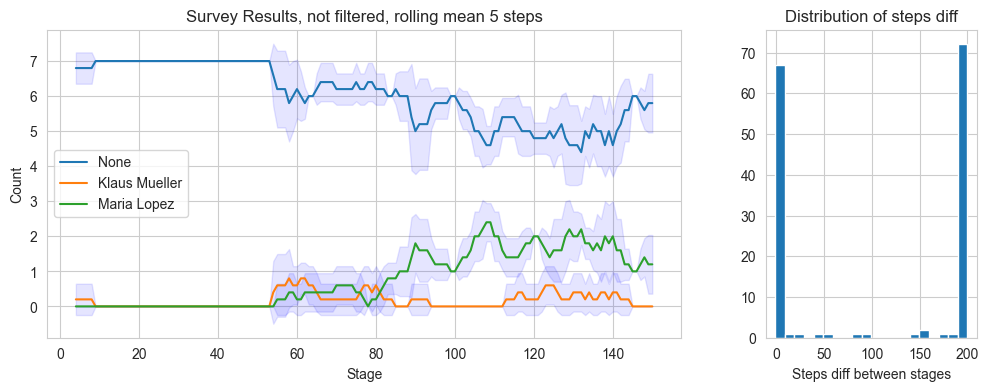

In [40]:
import matplotlib.pyplot as plt

df_survey = pd.DataFrame(results).fillna(0)
df = df_survey.drop("step", axis=1).reset_index(drop=True)

plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
plt.subplot(1, 2, 1)
ax = plt.gca()
window = 5
mean = df.rolling(window).mean()
std = df.rolling(window).std()
mean.plot(ax=ax)
for i in range(len(df.columns)):
    ax.fill_between(std.index, (mean-std).iloc[:, i].values, (mean+std).iloc[:, i].values, color='b', alpha=0.1)
plt.title(f"Survey Results, not filtered, rolling mean {window} steps")
plt.xlabel("Stage")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
final_steps = list(map(lambda x: int(x.split("-")[-2]), folders_sorted))
y = np.arange(0, len(final_steps))

# plt.figure(figsize=(10, 5))
# plt.scatter(final_steps, y, c="red", s=1)

plt.hist(np.diff(final_steps), bins=20)
plt.title("Distribution of steps diff")
plt.xlabel("Steps diff between stages")
plt.show()

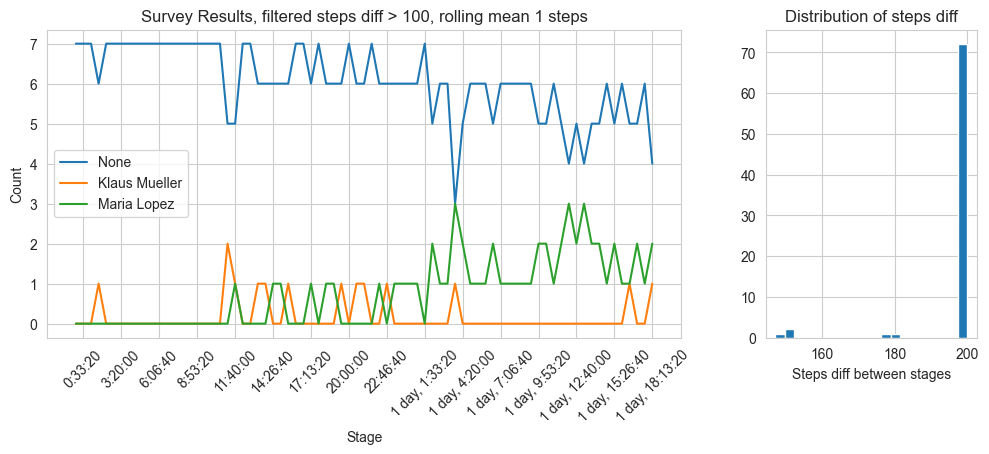

In [55]:
df_survey = pd.DataFrame(results).fillna(0)
final_steps_diff = np.diff(final_steps, prepend=0)
filtered_steps_mask = final_steps_diff > 100
filtered_steps = np.array(final_steps)[filtered_steps_mask]
df = df_survey.loc[filtered_steps_mask, :].drop("step", axis=1).reset_index(drop=True)

plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
plt.subplot(1, 2, 1)
ax = plt.gca()
window = 1
mean = df.rolling(window).mean()
std = df.rolling(window).std()
mean.plot(ax=ax)
for i in range(len(df.columns)):
    ax.fill_between(std.index, (mean-std).iloc[:, i].values, (mean+std).iloc[:, i].values, color='b', alpha=0.1)
plt.title(f"Survey Results, filtered steps diff > 100, rolling mean {window} steps")
plt.xlabel("Stage")
plt.ylabel("Count")
x_ticks_gran = 5
plt.xticks(
    [i for i in range(1, len(filtered_steps)+1, x_ticks_gran)], 
    labels = list(map(lambda x: x * datetime.timedelta(seconds=2000), [i for i in range(1, len(filtered_steps)+1, x_ticks_gran)])),
    rotation=45)

plt.subplot(1, 2, 2)
plt.hist(final_steps_diff[filtered_steps_mask], bins=20)
plt.xlabel("Steps diff between stages")
plt.title("Distribution of steps diff")
plt.show()

In [58]:
all_predictions[85]

[('I am still in the process of evaluating the candidates and their platforms. I plan to discuss my voting preferences with Adam Smith later today to get a better understanding of their policies and how they align with my values. I am considering both Klaus Mauller and Maria Lopez as potential candidates, and I want to make an informed decision before casting my vote in the upcoming elections.',
  'None'),
 ("I am planning to vote for Adam Smith in the upcoming elections. He has shown support for my environmental initiatives and campaign, and I believe he will prioritize environmental issues in his policy decisions. It's important to me that our leaders prioritize sustainability and conservation efforts for the future of our town.",
  'None'),
 ("I'm sorry, I am currently focused on my research on gentrification and collaboration with Maria. I believe our efforts in understanding societal issues through literature are important at the moment. So, I haven't had much time to delve into t

In [59]:
results

[{'step': '0', 'None': 7},
 {'step': '199', 'None': 7},
 {'step': '399', 'None': 7},
 {'step': '599', 'None': 7},
 {'step': '799', 'Klaus Mueller': 1, 'None': 6},
 {'step': '999', 'None': 7},
 {'step': '1199', 'None': 7},
 {'step': '1399', 'None': 7},
 {'step': '1599', 'None': 7},
 {'step': '1799', 'None': 7},
 {'step': '1999', 'None': 7},
 {'step': '2199', 'None': 7},
 {'step': '2399', 'None': 7},
 {'step': '2599', 'None': 7},
 {'step': '2799', 'None': 7},
 {'step': '2879', 'None': 7},
 {'step': '2878', 'None': 7},
 {'step': '2877', 'None': 7},
 {'step': '2876', 'None': 7},
 {'step': '2875', 'None': 7},
 {'step': '2874', 'None': 7},
 {'step': '2873', 'None': 7},
 {'step': '2872', 'None': 7},
 {'step': '2871', 'None': 7},
 {'step': '2870', 'None': 7},
 {'step': '2869', 'None': 7},
 {'step': '2868', 'None': 7},
 {'step': '2867', 'None': 7},
 {'step': '2866', 'None': 7},
 {'step': '2865', 'None': 7},
 {'step': '2864', 'None': 7},
 {'step': '2863', 'None': 7},
 {'step': '2862', 'None': 7}